In [1]:
import torch
from torch import nn # nn contains all ofPyTorch's building block for neural networks
import matplotlib.pyplot as plt
from pathlib import Path

torch.__version__

'2.2.2+cu121'

## 1. Data (preparing and loading)

In [2]:

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange( start, end, step).unsqueeze( dim=1)
y = weight * X + bias

In [3]:
X[ :10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [4]:
y[ :10]

tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])

In [5]:
len( X), len( y)

(50, 50)

### Splitting data into training and test set

In [6]:
train_split = int( 0.8 * len( X))

train_split

40

In [7]:
X_train, y_train = X[ :train_split], y[ :train_split]
X_test, y_test = X[ train_split:], y[ train_split:]

len( X_train), len( y_train), len( X_test), len( y_test)

(40, 40, 10, 10)

### Visualize

In [8]:
def plot_predictions( train_data, train_labels, test_data, test_labels, predictions=None):
	plt.figure( figsize=( 10, 7))

	plt.scatter( train_data, train_labels, c="b", s=4, label="Training Data")

	plt.scatter( test_data, test_labels, c="g", s=4, label="Testing Data")

	if predictions is not None:
		plt.scatter( test_data, predictions, c="r", s=4, label="Predictions")

	plt.legend( prop={ "size": 14})

	plt.show()

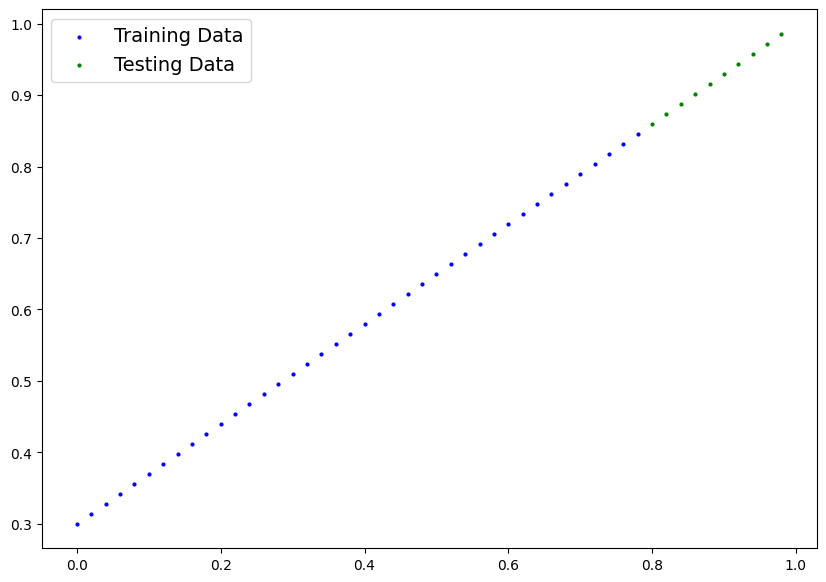

In [9]:
plot_predictions( X_train, y_train, X_test, y_test)

## 2. Build model

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a nn can be considered a computaional graph)
* torch.nn.Parameter - what parameters should our model try and learn (often defined in layers in torch.nn)
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [10]:
class LinearRegressionModel( nn.Module):
	def __init__( self):
		super().__init__()

		self.weights = nn.Parameter( torch.randn( 1, requires_grad=True, dtype=torch.float))

		self.bias = nn.Parameter( torch.randn( 1, requires_grad=True, dtype=torch.float))

	def forward( self, x: torch.Tensor) -> torch.Tensor:
		return self.weights * x + self.bias

In [11]:
torch.manual_seed( 42)

model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

In [12]:
list( model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make prediction with model

In [14]:
with torch.inference_mode():
	y_preds = model_0( X_test)

# with torch.no_grad():
# 	y_preds = model_0( X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

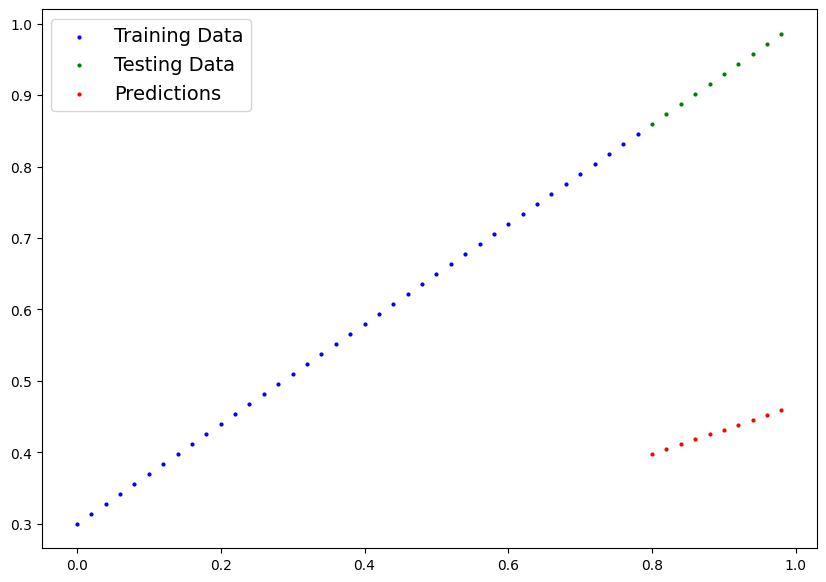

In [15]:
plot_predictions( X_train, y_train, X_test, y_test, y_preds)

## 3. Train model

* loss function
* optimizer
* training loop
* testing loop

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

loss_fn

L1Loss()

In [17]:
# Setup an optimizer
optimizer = torch.optim.SGD(
	params=model_0.parameters(),
	lr=0.01
)

### Builing a training & testing loop in PyTorch

0. Loop through the data
1. Forward pass (this involves data going through the model `forward()` function) to make predictions on data
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [18]:
# an epoch is one loop through the data... (this is a hyperparameter)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range( epochs):
	# set the model to training mode
	
	model_0.train() # train mode in PyTorch sets all parameters to require gradients

	# 1. Forward pass
	y_pred = model_0( X_train)

	# 2. Calculate the loss
	loss = loss_fn( y_pred, y_train)

	# 3. Optimizer zero grad
	optimizer.zero_grad() # zero the optimizer gradients because they accumulate

	# 4. Perform backpropagation on the loss with respect to the parameters of the mode
	loss.backward()

	# 5. Step the optimizer (perform gradient descent)
	optimizer.step() # by default the optimizer changes will accumulate the loop

	model_0.eval() # turns off different setting in the model evaluation/testing (dropout/batch norm layers)

	with torch.inference_mode(): # turns off gradient tracking
		# 1. Forward pass
		test_pred = model_0( X_test)

		# 2. Calculate the loss
		test_loss = loss_fn( test_pred, y_test)

	epoch_count.append( epoch)
	loss_values.append( loss)
	test_loss_values.append( test_loss)

	if epoch % 10 == 0:
		print( f"Epoch: { epoch} | Loss: { loss} | test loss: { test_loss}")

		print( model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

### Plot loss curves

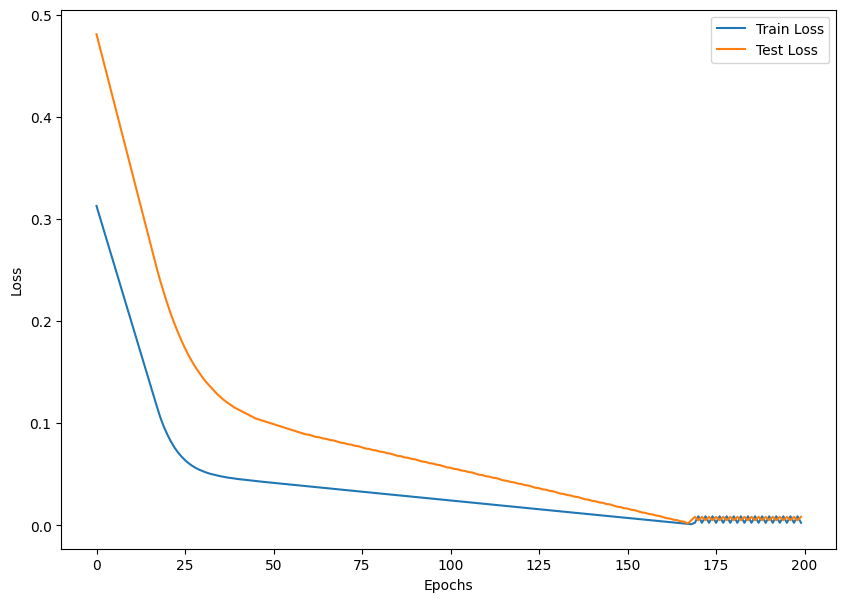

In [19]:
plt.figure( figsize=( 10, 7))
plt.plot( epoch_count, torch.tensor( loss_values).numpy(), label="Train Loss")
plt.plot( epoch_count, torch.tensor( test_loss_values).numpy(), label="Test Loss")
plt.ylabel( "Loss")
plt.xlabel( "Epochs")
plt.legend()
plt.show()

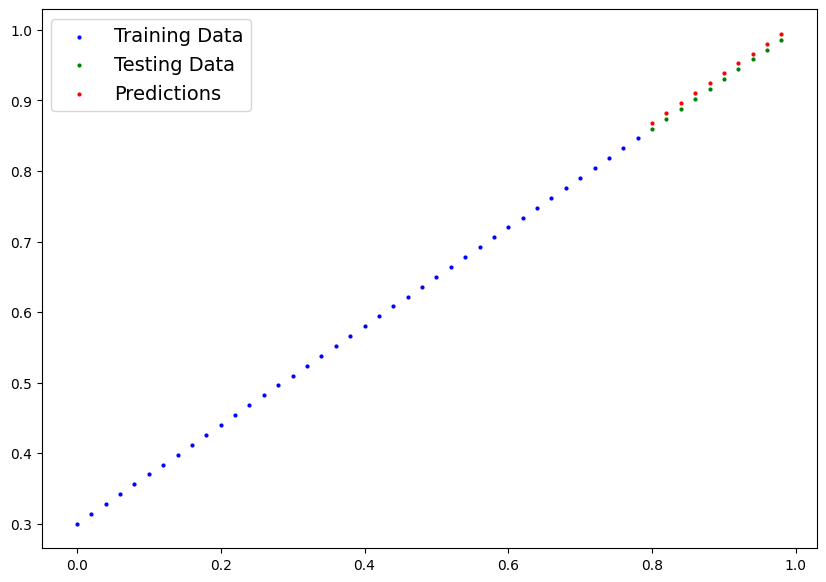

In [20]:
with torch.inference_mode():
	y_preds = model_0( X_test)

	plot_predictions( X_train, y_train, X_test, y_test, y_preds)

## 4. Saving a model

1. `torch.save()` - allows to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary

In [21]:
# 1. Create models directory
MODEL_PATH = Path( "models")
MODEL_PATH.mkdir( parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print( f"Saving model to: { MODEL_SAVE_PATH}")
torch.save(
	obj=model_0.state_dict(),
	f=MODEL_SAVE_PATH
)

Saving model to: models\01_pytorch_workflow_model_0.pth


## 5. Loading a PyTorch model

In [22]:
# instantiate a new instance of model
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0
loaded_model_0.load_state_dict( torch.load( f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

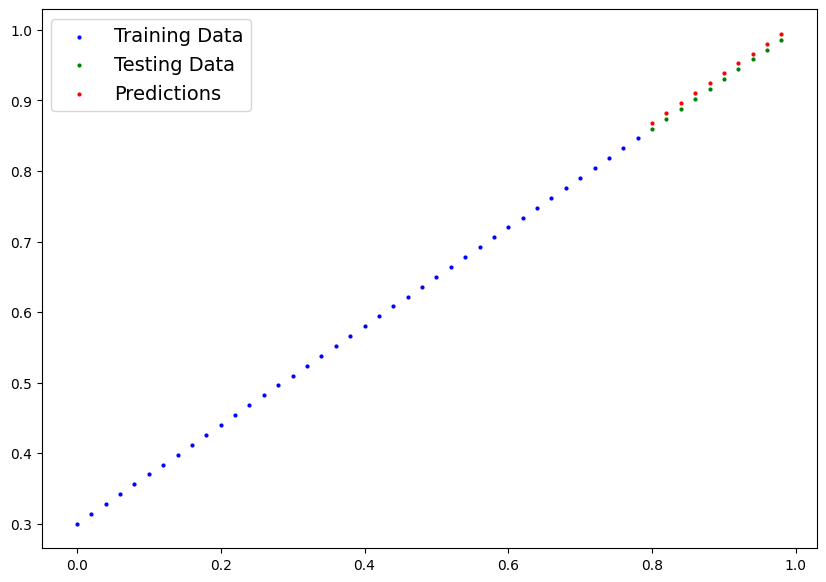

In [23]:
loaded_model_0.eval()

with torch.inference_mode():
	loaded_model_preds = loaded_model_0( X_test)

plot_predictions(
	X_train,
	y_train,
	X_test,
	y_test,
	loaded_model_preds
)